In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft, interpolate
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [23]:
n = 1000 
nx = n
ny = n

x = np.linspace(-np.pi,np.pi-(2*np.pi/n),n)
y = np.linspace(-np.pi,np.pi-(2*np.pi/n),n)

xlen = len(x)
ylen = len(y)

dx = x[1] - x[0]
dy = y[1] - y[0]
XX, YY = np.meshgrid(x,y)

a = 5
b = 5

ka = 1
kb = 1

c = 1
d = 1

kc = 2
kd = 2

f1 = a*np.sin(ka * YY) + c*np.cos(kc * XX)
f2 = c*np.cos(kb * XX) + d*np.sin(kd * YY)

In [24]:
def getFourierCoeffs(powerlaw, nx, ny, dx, dy):
    kx = fft.fftfreq(nx, dx)
    ky = fft.fftfreq(ny, dy)

    kX, kY = np.meshgrid(kx,ky)
    k_rad = np.sqrt(kX**2 + kY**2)
    k_max = np.max(k_rad)

    shifted_krad = fft.fftshift(k_rad)

    amp = np.empty_like(k_rad)
    amp[k_rad!=0] = k_rad[k_rad!=0]**(-powerlaw)

    amp[k_rad==0] = np.max(amp)

    coeffs = np.sqrt(amp)
    return coeffs

def getNoiseFromFourierCoeffs(coeffs, nx, ny):
    rand = np.random.rand(ny,nx)

    randCoeffs = fft.ifft2(rand, norm='forward') 
    coeffs = coeffs*randCoeffs

    noise = fft.ifft2(coeffs, norm='forward')
    noise = noise.real
    noise = noise/np.mean(noise)

    noise = gaussian_filter(noise, sigma=30, mode='wrap')
    noise = gaussian_filter(noise, sigma=10, mode='wrap')
    noise = gaussian_filter(noise, sigma=5, mode='wrap')
    return noise

def getNoise(powerlaw, nx, ny, dx, dy):
    coeffs = getFourierCoeffs(powerlaw, nx, ny, dx, dy)
    noise = getNoiseFromFourierCoeffs(coeffs, nx, ny)
    return noise

# f1 = getNoise(-5./3, nx, ny, dx, dy)
# f2 = getNoise(-5./3, nx, ny, dx, dy)      

1.0000000000000002


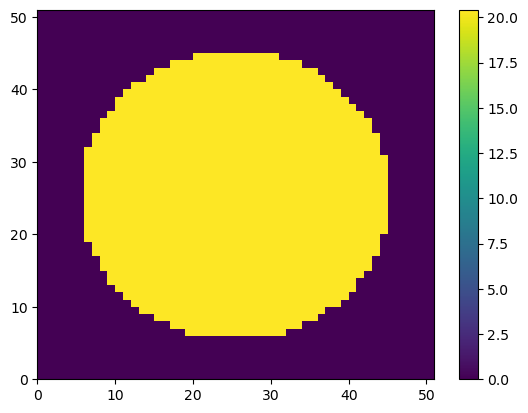

In [25]:
ell=1/4
half = ell/2 + 5*dx
xp = np.arange(-half, half+dx, dx)
xx, yy = np.meshgrid(xp, xp)

area = dx**2 * np.ones(xx.shape)
r = np.sqrt(xx**2 + yy**2)

kernel = np.empty_like(r)

kernel[r > ell/2] = 0.
kernel[r <= ell/2] = 1.
area[r > ell/2]  = 0

kernel /= np.sum(area)
plt.pcolormesh(kernel)
plt.colorbar()


print(np.sum(kernel*area))

In [26]:
f1bar = signal.convolve2d(f1, kernel*dx**2, mode='same', boundary='wrap')
f2bar = signal.convolve2d(f2, kernel*dx**2, mode='same', boundary='wrap')
f1f2bar = signal.convolve2d(f1*f2, kernel*dx**2, mode='same', boundary='wrap')

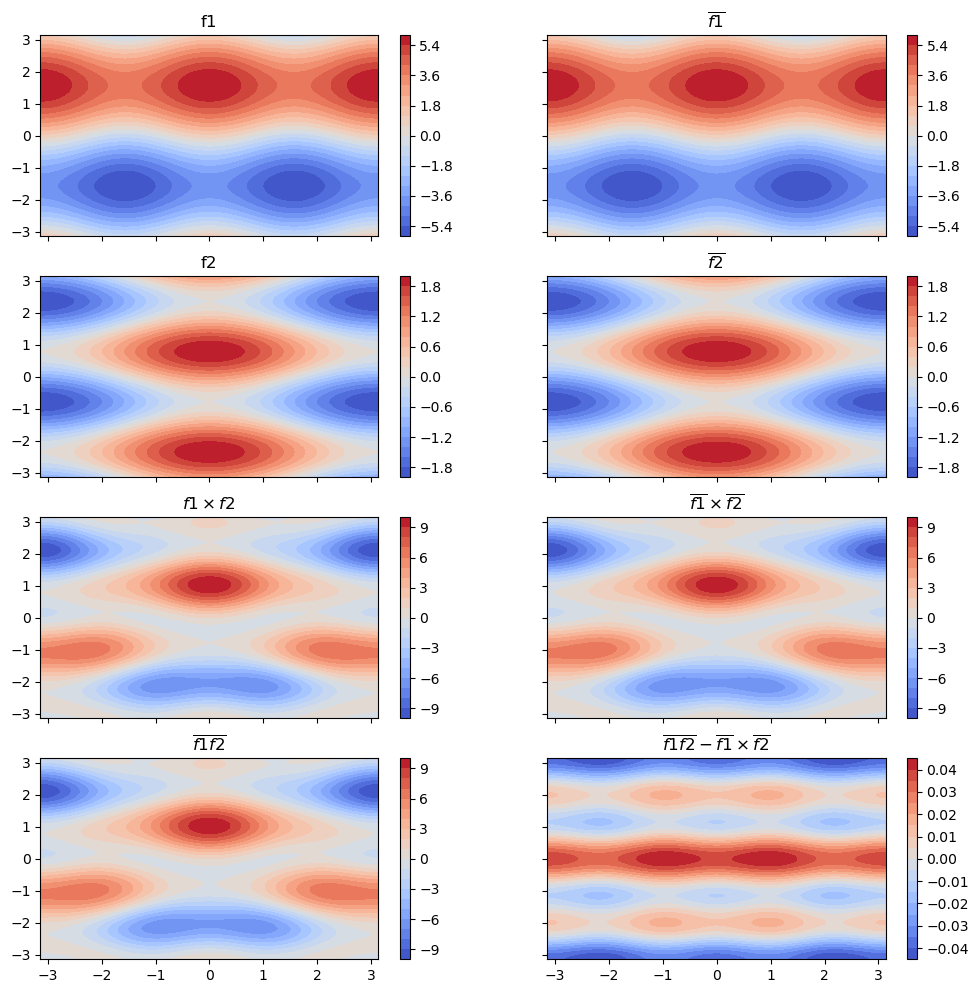

In [27]:
cmap = plt.get_cmap('coolwarm')

nlevels = 20

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey=True)
m = ax[0,0].contourf(x, y, f1, cmap = cmap, levels=nlevels)
ax[0,0].set_title('f1')
plt.colorbar(m, ax=ax[0, 0])

m = ax[0,1].contourf(x, y, f1bar, cmap = cmap, levels=nlevels)
ax[0,1].set_title(r'$\overline{f1}$')
plt.colorbar(m, ax=ax[0, 1])

m = ax[1,0].contourf(x, y, f2, cmap = cmap, levels=nlevels)
ax[1,0].set_title('f2')
plt.colorbar(m, ax=ax[1, 0])

m = ax[1,1].contourf(x, y, f2bar, cmap = cmap, levels=nlevels)
ax[1,1].set_title(r'$\overline{f2}$')
plt.colorbar(m, ax=ax[1, 1])

m = ax[2,0].contourf(x, y, f1*f2, cmap = cmap, levels=nlevels)
ax[2,0].set_title(r'$f1\times f2$')
plt.colorbar(m, ax=ax[2, 0])

m = ax[2,1].contourf(x, y, f1bar * f2bar, cmap = cmap, levels=nlevels)
ax[2,1].set_title(r'$\overline{f1}\times\overline{f2}$')
plt.colorbar(m, ax=ax[2, 1])


m = ax[3,0].contourf(x, y, f1f2bar, cmap = cmap, levels=nlevels)
ax[3,0].set_title(r'$\overline{f1f2}$')
plt.colorbar(m, ax=ax[3, 0])

m = ax[3,1].contourf(x, y, f1f2bar - f1bar * f2bar, cmap = cmap, levels=nlevels)
ax[3,1].set_title(r'$\overline{f1f2} - \overline{f1}\times\overline{f2}$')
plt.colorbar(m, ax=ax[3, 1])

In [28]:
def GetGradient_POP2(Array2D, DXU, DYU, UAREA):
    p = -1
    m = 1
    x = 1
    y = 0
    topRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (p,p), axis=(y,x)) +\
               np.roll(Array2D, p, axis=y))
    
    topLeft = 0.25*(Array2D + np.roll(Array2D, p, axis=y) +\
               np.roll(Array2D, (p,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=x))
    
    bottomRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (m,p), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    bottomLeft = 0.25*(Array2D + np.roll(Array2D, m, axis=x) +\
               np.roll(Array2D, (m,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    gradx = 0.5*(topRight + bottomRight - topLeft - bottomLeft)/DX
    grady = 0.5*(topRight + topLeft - bottomRight - bottomLeft)/DY
    
    return gradx, grady

def GetGradient_order(phi, DX, DY):
    n=4
    coeffs = np.array([1./280, -4./105, 1./5, -4./5, 0, 4./5, -1./5, 4./105, -1./280], dtype=float)
    

    dx_phi = np.zeros(phi.shape, dtype=float)
    dy_phi = np.zeros(phi.shape, dtype=float)
    
    
    for i in range(-n, n+1):
        dx_phi += np.roll(phi, i, axis = 1) * -coeffs[n+i]
        dy_phi += np.roll(phi, i, axis = 0) * -coeffs[n+i]
        #print(i, coeffs[n+i])
    
    dx_phi = dx_phi/DX
    dy_phi = dy_phi/DY
    
    return dx_phi, dy_phi

def GetGradient(phi, DX, DY, UAREA):
    dx_phi, dy_phi = GetGradient_POP2(phi, DX, DY, UAREA)     
    return dx_phi, dy_phi


def getModelVal(f1_bar, f2_bar, DX, DY, ell):
    C_2 = (ell**2)/8
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY, DX*DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY, DX*DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2

    model *= C_2

    return model

def getModel2Val(f1_bar, f2_bar, DX, DY, ell):
    C_2 = 0.125
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY, DX*DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY, DX*DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2

    model *= (1/2 * (ell)**2 * C_2)

    return model

In [29]:
DX = np.full(XX.shape, dx)
DY = np.full(XX.shape, dx)

truth = f1f2bar - f1bar*f2bar
model = getModelVal(f1bar, f2bar, DX, DY, ell)
model2 = getModel2Val(f1bar, f2bar, DX, DY, ell)

(1000, 1000)
1000 1000 0 1000


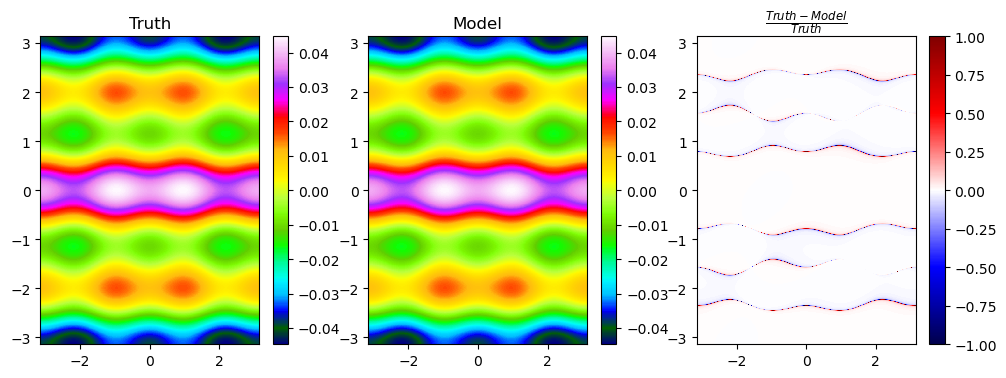

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

v = np.max(truth)
v2 = 1

n=0

x1,x2 = n,xlen-n
y1,y2 = n,ylen-n

cmap = plt.get_cmap('gist_ncar')
p = ax[0].pcolormesh(x[x1:x2], y[y1:y2], truth[y1:y2, x1:x2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[0])
ax[0].set_title('Truth')

p = ax[1].pcolormesh(x[x1:x2], y[y1:y2], model2[y1:y2, x1:x2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[1])
ax[1].set_title('Model')

p = ax[2].pcolormesh(x[x1:x2], y[y1:y2], (truth[y1:y2, x1:x2] - model2[y1:y2, x1:x2])/truth[y1:y2, x1:x2], 
                   cmap='seismic', vmin=-v2, vmax=v2)
plt.colorbar(p, ax=ax[2])
ax[2].set_title(r'$\frac{Truth - Model}{Truth}$')

print(truth[y1:y2, x1:x2].shape)
print(ylen, xlen, y1, y2)

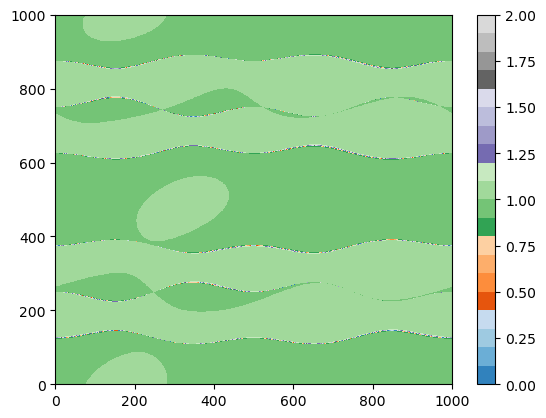

In [31]:
plt.pcolormesh(model2/truth, vmin=0, vmax=2, cmap='tab20c')
plt.colorbar()

In [32]:
C = 2*np.pi*(np.sin(0.5))**2